In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import mne
import mne_connectivity
from mne_connectivity import phase_slope_index, seed_target_indices, spectral_connectivity_epochs
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import fooof
# Import plotting functions
from fooof.plts.spectra import plot_spectrum, plot_spectra
# Import the FOOOF object
from fooof import FOOOF
from fooof import FOOOFGroup
import os 
import joblib
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pickle
from tqdm import tqdm
from IPython.display import clear_output
import warnings 

# I only want to see warnings once
warnings.filterwarnings('ignore')

from joblib import delayed, Parallel
from statsmodels.stats import multitest

Note: If you have installed this package in editable form on Minerva, you must append the local path! This is because Minerva requires that you point your package installs away from the local directory for space reasons, but editable packages have to be installed locally.

In [3]:
import sys
sys.path.append('/hpc/users/qasims01/resources/LFPAnalysis')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils, oscillation_utils, statistics_utils


## First, get the behavior data

This is from another notebook with a kernel and environment specifically for beahvior

In [5]:
base_dir = '/sc/arion' # this is the root directory for most un-archived data and results
load_dir = f'{base_dir}/work/qasims01/MemoryBanditData/EMU'

# Load the demographics data to get information about who has run the task
demo_file = f'{base_dir}/projects/guLab/Salman/EMU/MemoryBanditsDatabase.xlsx'
demo_data = pd.read_excel(demo_file, engine='openpyxl')
subj_df = demo_data[(demo_data.LongVersion==1) & (demo_data.Minerva==1)]

# Let's get rid of Iowa patients for now 

# subj_df = subj_df[subj_df.Site!='UI']
subj_df = subj_df[~subj_df['MSSMCode'].isin(['MS015', 'MS024', 'MS034', 'MS038'])]


days = ['Day1', 'Day2']
subj_ids = subj_df.MSSMCode.values
subj_formats = subj_df.format.values
subj_sites = subj_df.Site.values
subj_days = subj_df.Day2.values

In [30]:
# load behavioral data
learn_df = pd.read_csv(f'{load_dir}/learn_df_RWH.csv')
combined_df = pd.read_csv(f'{load_dir}/full_df_RWH.csv')



The following function provides a parallelized function for extracting time-resolved data from the TFRs (averaged across band). 

In [ ]:
%%time
progress_bar = tqdm(subj_ids, ascii=True, desc='Saving TFR dataframes for time-resolved data')

power_epochs = {f'{a}': {f'{b}': np.nan for b in analysis_evs} for a in subj_ids}

for subj_id in progress_bar:
    for day in ['Day1']:
        elec_df = pd.read_csv(f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/{day}_reref_elec_df')
        for event in analysis_evs:

            filepath = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{sutbj_id}/scratch/TFR'
            if not os.path.exists(f'{filepath}/{event}/plots'):
                os.makedirs(f'{filepath}/{event}/plots')
            if not os.path.exists(f'{filepath}/{event}/dfs'):
                os.makedirs(f'{filepath}/{event}/dfs')

            power_epochs[subj_id][event] = mne.time_frequency.read_tfrs(f'{filepath}/{event}-tfr.h5')[0]

            epochs_to_analyze = learn_df[(learn_df.participant==subj_id)].trials.values - 1

            power_epochs[subj_id][event] = power_epochs[subj_id][event][epochs_to_analyze.astype(int)]

            power_epochs[subj_id][event].metadata = learn_df[(learn_df.participant==subj_id)]
            
            # If you want to crop to a specific time, do so here: 
            
            
            
            
            bands=['hfa']
            
            # Run the regression code in parallel
            Parallel(n_jobs=-1, verbose=1)(delayed(statistic_utils.tfr_to_bandavg_timeseries)(chan,
                                                                              power_epochs[subj_id][event], 
                                                                              subj_id, 
                                                                              elec_df, 
                                                                              event,
                                                                              bands) for chan in power_epochs[subj_id][event].ch_names)


Saving TFR dataframes for time-resolved data:   0%|          | 0/16 [00:00<?, ?it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS012/scratch/TFR/feedback_start-tfr.h5 ...
Adding metadata with 83 columns
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 25 concurrent workers.


done with subject MS012 channel raglt5-raglt6
done with subject MS012 channel rhplt4-rhplt5
done with subject MS012 channel rmolf6-rmolf7
done with subject MS012 channel raglt4-raglt5
done with subject MS012 channel rhplt5-rhplt6
done with subject MS012 channel rmolf7-rmolf8
done with subject MS012 channel racas8-racas9
done with subject MS012 channel rhplt6-rhplt7
done with subject MS012 channel rmolf9-rmolf11
done with subject MS012 channel rals3-rals4
done with subject MS012 channel rmcms1-rmcms2
done with subject MS012 channel rmtpt2-rmtpt3
done with subject MS012 channel raglt8-raglt9
done with subject MS012 channel rhplt7-rhplt8
done with subject MS012 channel rmtpt1-rmtpt2
done with subject MS012 channel raglt7-raglt8
done with subject MS012 channel rmcms3-rmcms4
done with subject MS012 channel rmtpt3-rmtpt4
done with subject MS012 channel racas9-racas10
done with subject MS012 channel rmcms4-rmcms5
done with subject MS012 channel rmtpt4-rmtpt5
done with subject MS012 channel ra

[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed: 26.9min finished
Saving TFR dataframes for time-resolved data:   6%|6         | 1/16 [26:56<6:44:13, 1616.93s/it]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS015/scratch/TFR/feedback_start-tfr.h5 ...
Adding metadata with 64 columns
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 25 concurrent workers.


Here, we are going to average across time, and within frequency band: 

In [10]:
progress_bar = tqdm(subj_ids, ascii=True, desc='Saving TFR dataframes')
analysis_evs = ['feedback_start'] 

# power_epochs = {f'{a}': {f'{b}': np.nan for b in analysis_evs} for a in subj_ids}


for subj_id in subj_ids:
    for day in ['Day1']:
        elec_df = pd.read_csv(f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/{day}_reref_elec_df')
        for event in analysis_evs:

            filepath = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/scratch/TFR'
            if not os.path.exists(f'{filepath}/{event}/plots'):
                os.makedirs(f'{filepath}/{event}/plots')
            if not os.path.exists(f'{filepath}/{event}/dfs'):
                os.makedirs(f'{filepath}/{event}/dfs')

            power_epochs = mne.time_frequency.read_tfrs(f'{filepath}/{event}-tfr.h5')[0]
            
            # 5/3/2024
            # If we care about both RPE and memory in encoding (we dont yet!)
#             epochs_to_analyze = combined_df[(combined_df.participant==subj_id) & (combined_df.condition=='Day1')].dropna(subset=['trials_gamble']).sort_values(by='trials_gamble').reset_index(drop=True).trials_gamble.values - 1

#             power_epochs = power_epochs[epochs_to_analyze.astype(int)]

            power_epochs.metadata = learn_df[(learn_df.participant==subj_id)]

            for chan in power_epochs.ch_names:
                pow_df = power_epochs.copy().pick([chan]).to_data_frame()
                
                # If i want to truncate: 
                # pow_df = pow_df[pow_df.time<1.0]
                
                pow_df['fband'] = pow_df.freq.apply(lambda x: 'theta' if x<=8 else 'alpha' if (x>=8) & (x<=13) else 'beta' if (x>=13) & (x<=30) else 'gamma' if (x>=30) & (x<=70) else 'hfa')
                                
                pow_df = pow_df.groupby(['fband','epoch']).mean().reset_index()
                
                tfr_df = pow_df.drop(columns=['time', 'freq']).rename(columns={'epoch':'trial', f'{chan}':'tfr'})

                power_epochs.metadata['trial'] = tfr_df['trial'].unique()
                tfr_df = tfr_df.merge(power_epochs.metadata, on=['trial'])

                tfr_df.insert(0,'channel', chan)
                tfr_df.insert(0,'region', elec_df[elec_df.label==chan].salman_region.values[0])
#                 tfr_df.insert(0,'participant', subj_id)
                tfr_df['event'] = event
    
                # indicate bad epochs here (based on IEDs or 60 Hz noise): 
#                 tfr_df['good_epoch'] = 1 
#                 bad_epochs = np.unique(np.where(np.isnan(power_epochs[subj_id][event].copy().pick([chan])._data))[0])

#                 tfr_df.loc[tfr_df['trial'].isin(bad_epochs), 'good_epoch'] = 0

                tfr_df.to_csv(f'{filepath}/{event}/dfs/{chan}_time_averaged_df.csv', index=False)



Saving TFR dataframes:   0%|          | 0/19 [00:27<?, ?it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS012/scratch/TFR/feedback_start-tfr.h5 ...


Adding metadata with 60 columns
Replacing existing metadata with 21 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/UI001/scratch/TFR/feedback_start-tfr.h5 ...
Adding metadata with 48 columns
Replacing existing metadata with 21 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS016/scratch/TFR/feedback_start-tfr.h5 ...
Adding metadata with 65 columns
Replacing existing metadata with 21 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS017/scratch/TFR/feedback_start-tfr.h5 ...
Adding metadata with 55 columns
Replacing existing metadata with 21 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/UI002/scratch/TFR/feedback_start-tfr.h5 ...
Adding metadata with 115 columns
Replacing existing metadata with 21 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS019/scratch/TFR/feedback_start-tfr.h5 ...
Adding metadata with 67 columns
Replacing existing metadata with 21 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses

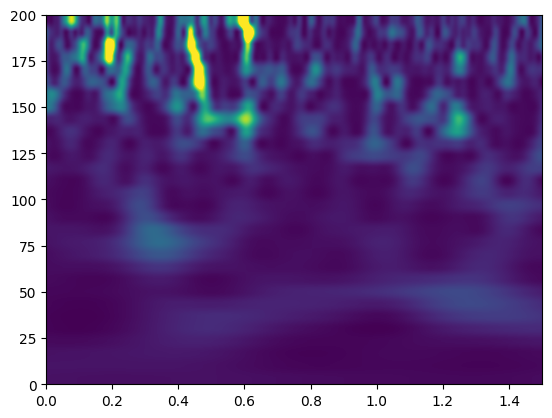

In [106]:
plt.imshow(power_epochs[subj_id][event]._data[unique_pairs[1][1], unique_pairs[1][0], :, :], extent=[0, 1.5, 0, 200],
           aspect='auto',  origin='lower', vmax=10)

In [32]:
progress_bar = tqdm(subj_ids, ascii=True, desc='Saving TFR dataframes')
analysis_evs = ['cue_on'] 

power_epochs = {f'{a}': {f'{b}': np.nan for b in analysis_evs} for a in subj_ids}


for subj_id in subj_ids:
    for day in ['Day1']:
        elec_df = pd.read_csv(f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/{day}_reref_elec_df')
        for event in analysis_evs:

            filepath = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/scratch/TFR'
            if not os.path.exists(f'{filepath}/{event}/plots'):
                os.makedirs(f'{filepath}/{event}/plots')
            if not os.path.exists(f'{filepath}/{event}/dfs'):
                os.makedirs(f'{filepath}/{event}/dfs')

            power_epochs = mne.time_frequency.read_tfrs(f'{filepath}/{event}-tfr.h5')[0]

#             # These epochs only grab those images that were later involved in memory recognition: 
            epochs_to_analyze = combined_df[(combined_df.participant==subj_id) & (combined_df.condition=='Day1')].dropna(subset=['trials_gamble']).sort_values(by='trials_gamble').reset_index(drop=True).trials_gamble.values - 1

            power_epochs = power_epochs[epochs_to_analyze.astype(int)]

            power_epochs.metadata = combined_df[(combined_df.participant==subj_id) & (combined_df.condition=='Day1')].dropna(subset=['trials_gamble']).sort_values(by='trials_gamble').reset_index(drop=True)

            for chan in power_epochs.ch_names:
                pow_df = power_epochs.copy().pick([chan]).to_data_frame()
                
                # If i want to truncate: 
                # pow_df = pow_df[pow_df.time<1.0]
                
                pow_df['fband'] = pow_df.freq.apply(lambda x: 'theta' if x<=8 else 'alpha' if (x>=8) & (x<=13) else 'beta' if (x>=13) & (x<=30) else 'gamma' if (x>=30) & (x<=70) else 'hfa')
                pow_df = pow_df.groupby(['fband','epoch']).mean().reset_index()
                
                tfr_df = pow_df.drop(columns=['time', 'freq']).rename(columns={'epoch':'trial', f'{chan}':'tfr'})
                
                # NOTE: tfr is NAN for BAD EPOCHS as indicated bad based on IEDs or 60 Hz noise: 

                power_epochs.metadata['trial'] = tfr_df['trial'].unique()
                tfr_df = tfr_df.merge(power_epochs.metadata, on=['trial'])

                tfr_df.insert(0,'channel', chan)
                tfr_df.insert(0,'region', elec_df[elec_df.label==chan].salman_region.values[0])
#                 tfr_df.insert(0,'participant', subj_id)
                tfr_df['event'] = event
    
                # indicate bad epochs here (based on IEDs or 60 Hz noise): 
#                 tfr_df['good_epoch'] = 1 
#                 bad_epochs = np.unique(np.where(np.isnan(power_epochs[subj_id][event].copy().pick([chan])._data))[0])

#                 tfr_df.loc[tfr_df['trial'].isin(bad_epochs), 'good_epoch'] = 0


                tfr_df.to_csv(f'{filepath}/{event}/dfs/{chan}_time_averaged_df.csv', index=False)


Saving TFR dataframes:   0%|          | 0/19 [00:41<?, ?it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS012/scratch/TFR/cue_on-tfr.h5 ...


Not setting metadata
Adding metadata with 60 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/UI001/scratch/TFR/cue_on-tfr.h5 ...
Not setting metadata
Adding metadata with 60 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS016/scratch/TFR/cue_on-tfr.h5 ...
Not setting metadata
Adding metadata with 60 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS017/scratch/TFR/cue_on-tfr.h5 ...
Not setting metadata
Adding metadata with 60 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/UI002/scratch/TFR/cue_on-tfr.h5 ...
Not setting metadata
Adding metadata with 60 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS019/scratch/TFR/cue_on-tfr.h5 ...
Not setting metadata
Adding metadata with 60 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS020/scratch/TFR/cue_on-tfr.h5 ...
Not setting metadata
Adding metadata with 60 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS022/scratch/TFR/cue_on-tfr.h5 ...

In [27]:
combined_df[(combined_df.participant==subj_id)].dropna(subset=['trials_gamble']).sort_values(by='trials_gamble').reset_index(drop=True).condition




0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
10   NaN
11   NaN
12   NaN
13   NaN
14   NaN
15   NaN
16   NaN
17   NaN
18   NaN
19   NaN
20   NaN
21   NaN
22   NaN
23   NaN
24   NaN
25   NaN
26   NaN
27   NaN
28   NaN
29   NaN
30   NaN
31   NaN
32   NaN
33   NaN
34   NaN
35   NaN
36   NaN
37   NaN
38   NaN
39   NaN
Name: condition, dtype: float64

Here, we are going to average within frequency band only, and sub-sample time

## time-averaged regression

In [23]:
chan_dfs = [] 
glms = []
elec_counter = 0 
for subj_id in tqdm(subj_ids):
    day = 'Day1'
    filepath = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/scratch/TFR'
    elec_df = pd.read_csv(f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/{day}_reref_elec_df')
    for event in analysis_evs:
        for chan in elec_df.label.unique():
            # for chan in tqdm(ch_names, ascii=True, desc='Loading TFR dataframes'): 
            chan_df = pd.read_csv(f'{filepath}/{event}/dfs/{chan}_time_averaged_df.csv')
            
            chan_df['unique_elec_id'] = elec_counter
            chan_df['zrpe'] = zscore(chan_df.rpe)
            chan_df['zpm'] = zscore(chan_df.DPRIME)
            chan_df['gamble_rt_log'] = np.log(chan_df['gamble_rt'])
            elec_counter +=1
            
#             # Do electrode-level models: 
#             formula = 'tfr ~ zrpe + zpm'

#             for band in chan_df.fband.unique():
#                 mod_df = chan_df[(chan_df.fband==band)].reset_index()
#                 mod_df.dropna(subset=['tfr', 'zrpe', 'zpm', 'hits', 'choice'], inplace=True)
#                 mod_df = mod_df.groupby('trial').mean().reset_index()
                
#                 mod = smf.ols(formula=formula, data=mod_df).fit()

#                 df_summary = pd.DataFrame(mod.summary().tables[1].data)
#                 df_summary.columns = ['params', 'coef', 'se', 't', 'p', 'ci_low', 'ci_high']
#                 df_summary.drop(index=df_summary.index[0], axis=0, inplace=True)

#                 df_summary.coef = df_summary.coef.astype(float)
#                 df_summary.p = df_summary.p.astype(float)
#                 df_summary = df_summary[df_summary.params!='Intercept']
                
#                 df_summary['participant'] = subj_id
#                 df_summary['chan'] = chan
#                 df_summary['region'] = elec_df[elec_df.label==chan].salman_region.values[0]
#                 df_summary['fband'] = band
            
#                 glms.append(df_summary) 

            chan_dfs.append(chan_df)
        
chan_dfs = pd.concat(chan_dfs)
# glms = pd.concat(glms)


100%|██████████| 17/17 [00:08<00:00,  1.97it/s]


In [26]:
chan_dfs.head(5)

,region,channel,fband,trial,tfr,gamble,gamble_start,gamble_rt,img_path,prob,...,male,female,alpha,beta,rpe,event,unique_elec_id,zrpe,zpm,gamble_rt_log
0,ACC,racas1-racas2,alpha,0,-0.070791,0,234.674028,7.453226,Google_1_Alberta Davenport_7_oval.png,1.0,...,1,0,0.655358,4.979471,0.5,feedback_start,0,1.300639,0.944048,2.008647
1,ACC,racas1-racas2,beta,0,0.024782,0,234.674028,7.453226,Google_1_Alberta Davenport_7_oval.png,1.0,...,1,0,0.655358,4.979471,0.5,feedback_start,0,1.300639,0.944048,2.008647
2,ACC,racas1-racas2,hfa,0,0.009924,0,234.674028,7.453226,Google_1_Alberta Davenport_7_oval.png,1.0,...,1,0,0.655358,4.979471,0.5,feedback_start,0,1.300639,0.944048,2.008647
3,ACC,racas1-racas2,slowgamma,0,-0.120373,0,234.674028,7.453226,Google_1_Alberta Davenport_7_oval.png,1.0,...,1,0,0.655358,4.979471,0.5,feedback_start,0,1.300639,0.944048,2.008647
4,ACC,racas1-racas2,theta,0,0.444570,0,234.674028,7.453226,Google_1_Alberta Davenport_7_oval.png,1.0,...,1,0,0.655358,4.979471,0.5,feedback_start,0,1.300639,0.944048,2.008647


In [81]:
formula = 'tfr ~ zrpe + zpm + alpha + beta' 
model_df = chan_dfs[(chan_dfs.fband=='slowgamma') & (chan_dfs.region=='HPC')].reset_index(drop=True).dropna(subset=['tfr', 'zrpe', 'zpm', 'unique_elec_id'])
model = smf.mixedlm(data=model_df, formula=formula, groups=model_df['unique_elec_id']).fit() 



In [82]:
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:            MixedLM Dependent Variable: tfr      
No. Observations: 6724    Method:             REML     
No. Groups:       85      Scale:              0.0662   
Min. group size:  65      Log-Likelihood:     -487.3185
Max. group size:  80      Converged:          Yes      
Mean group size:  79.1                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.029    0.019  1.502 0.133 -0.009  0.066
zrpe          0.008    0.003  2.452 0.014  0.002  0.014
zpm          -0.003    0.003 -0.905 0.365 -0.009  0.003
alpha        -0.023    0.039 -0.604 0.546 -0.099  0.052
beta         -0.003    0.005 -0.524 0.600 -0.013  0.008
Group Var     0.002    0.002                           
=======================================================

"""

In [28]:
chan_dfs[chan_dfs.fband=='hfa']['participant']

2      MS012
7      MS012
12     MS012
17     MS012
22     MS012
       ...  
377    MS038
382    MS038
387    MS038
392    MS038
397    MS038
Name: participant, Length: 89360, dtype: object

In [254]:
# Apply FDR correction to each column
from statsmodels.stats import multitest
        
# Apply FDR correction to each numeric column
def apply_fdr_correction(series):
    _, p_adjusted, _, _ = multitest.multipletests(series, method='fdr_bh')
    return p_adjusted

        
coef_dfs = []
p_dfs = [] 
for subj in glms.participant.unique():
    subj_df = glms[glms.participant==subj]
    for chan in subj_df.chan.unique():
        
        test_df = subj_df[subj_df.chan==chan].groupby(['fband', 'params']).mean().reset_index()
        # Pivot the DataFrame
        coef_df = test_df.pivot(index='fband', columns='params', values='coef').reset_index()
        # Reset the index to make 'fband' a column again
        # If you don't want to reset the index, you can skip the next line
        coef_df = coef_df.reset_index(drop=True)
        # Rename the index column
        coef_df.columns.name = None

        # Pivot the DataFrame
        pval_df = test_df.pivot(index='fband', columns='params', values='p').reset_index()
        # Reset the index to make 'fband' a column again
        # If you don't want to reset the index, you can skip the next line
        pval_df = pval_df.reset_index(drop=True)
        # Rename the index column
        pval_df.columns.name = None

        # Select only numeric columns
        numeric_columns = pval_df.select_dtypes(include='number')
        
        fdr_df = numeric_columns.apply(apply_fdr_correction)

        fdr_df['fband'] = pval_df['fband']

        coef_df['participant'] = subj
        coef_df['chan'] = chan
        coef_df['region'] = subj_df[subj_df.chan==chan].region.unique()[0]
        coef_dfs.append(coef_df)

        fdr_df['participant'] = subj
        fdr_df['chan'] = chan
        fdr_df['region'] = subj_df[subj_df.chan==chan].region.unique()[0]
        p_dfs.append(fdr_df)

In [255]:
all_p_df= pd.concat(p_dfs)
all_p_df = all_p_df[all_p_df.region!='Unknown']
numeric_columns = all_p_df.select_dtypes(include='number')

In [256]:
all_coef_df = pd.concat(coef_dfs)
all_coef_df = all_coef_df[all_coef_df.region!='Unknown']


In [138]:
g = sns.FacetGrid(all_coef_df, 
                  row='region', 
                  height=7.5, sharey=True, sharex=True)

g.map(sns.barplot, "fband", "zrpe",  errorbar='se', order=['theta', 'alpha', 'beta', 'slowgamma', 'hfa'])


In [139]:
g = sns.FacetGrid(all_coef_df, 
                  row='region', 
                  height=7.5, sharey=True, sharex=True)

g.map(sns.barplot, "fband", "zpm",  errorbar='se', order=['theta', 'alpha', 'beta', 'slowgamma', 'hfa'])


## Load the dataframes for the time-resolved regression

In [123]:
band_regress_dfs = []
for subj_id in progress_bar:
    filepath = f'/sc/arion/projects/guLab/Salman/EphysAnalyses/{subj_id}/scratch/TFR'
    for day in ['Day1']:
        elec_df = pd.read_csv(f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/{day}_reref_elec_df')
        for event in analysis_evs:
            for chan in elec_df.label.unique():
                if chan == 'Unknown':
                    continue
                else:
                    band_regress_df = pd.read_csv(f'{filepath}/{event}/dfs/{chan}_time_regressed_surr.csv')
                    band_regress_df = band_regress_df[band_regress_df.region!='Unknown']
                    # add subject - oops
                    band_regress_df['subj'] = subj_id
                    # check significance
                    band_regress_df['rpe_sig_upper'] = np.nan
                    band_regress_df['rpe_sig_lower'] = np.nan
                    band_regress_df['DPRIME_sig_upper'] = np.nan
                    band_regress_df['DPRIMe_sig_lower'] = np.nan
                    for band in band_regress_df.fband.unique():
                        band_regress_df['rpe_sig_upper'][band_regress_df.fband==band] = int(any(band_regress_df[band_regress_df.fband==band].rpe_p_upper_fdr<=0.025))
                        band_regress_df['rpe_sig_lower'][band_regress_df.fband==band] = int(any(band_regress_df[band_regress_df.fband==band].rpe_p_lower_fdr<=0.025))
                        band_regress_df['DPRIME_sig_upper'][band_regress_df.fband==band] = int(any(band_regress_df[band_regress_df.fband==band].DPRIME_p_upper_fdr<=0.025))
                        band_regress_df['DPRIMe_sig_lower'][band_regress_df.fband==band] = int(any(band_regress_df[band_regress_df.fband==band].DPRIME_p_lower_fdr<=0.025))
                    band_regress_dfs.append(band_regress_df)

In [ ]:
plot_df = band_regress_dfs[104]
for band in ['theta', 'alpha', 'beta', 'hfa']:
    for feature in ['rpe', 'DPRIME']:
        sig_time_pts_upper = plot_df[(plot_df.fband==band) & (plot_df[f'{feature}_p_upper_fdr']<=0.025)].ts
        sig_time_pts_lower = plot_df[(plot_df.fband==band) & (plot_df[f'{feature}_p_lower_fdr']<=0.025)].ts
        
        if (len(sig_time_pts_upper) > 0) | (len(sig_time_pts_lower) >0):
            fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)
            sns.lineplot(data=plot_df[plot_df.fband==band], x='ts', y=f'{feature}')
            plt.plot(sig_time_pts_upper,
                     [plt.ylim()[1]]*len(sig_time_pts_upper), 'o')
            plt.plot(sig_time_pts_lower,
                     [plt.ylim()[0]]*len(sig_time_pts_lower), 'o')
            plt.suptitle(f'{band}_{feature}_{plot_df.region.unique()[0]}')

In [76]:
features = ['rpe', 'DPRIME']
sig_chans = {f'{x}':[] for x in features}
sig_regions = {f'{x}':[] for x in features}
for plot_df in band_regress_dfs:
    for band in ['beta']:
        for feature in features:
            sig_time_pts_upper = plot_df[(plot_df.fband==band) & (plot_df[f'{feature}_p_upper_fdr']<=0.025)].ts
            sig_time_pts_lower = plot_df[(plot_df.fband==band) & (plot_df[f'{feature}_p_lower_fdr']<=0.025)].ts
            if (len(sig_time_pts_upper) > 0) | (len(sig_time_pts_lower) >0):
                sig_chans[feature].append(plot_df.chan.unique()[0]) 
                sig_regions[feature].append(plot_df.region.unique()[0])

In [77]:
from collections import Counter
sig_chan_dfs = [] 
for feature in features:
    sig_chan_df = pd.DataFrame(columns=['region', 'count', 'feature'])
    sig_chan_df['region'] = Counter(sig_regions[feature]).keys()
    sig_chan_df['count'] = Counter(sig_regions[feature]).values()
    sig_chan_df['feature'] = feature 
    sig_chan_dfs.append(sig_chan_df) 
sig_chan_dfs = pd.concat(sig_chan_dfs)  

<AxesSubplot:xlabel='region', ylabel='count'>

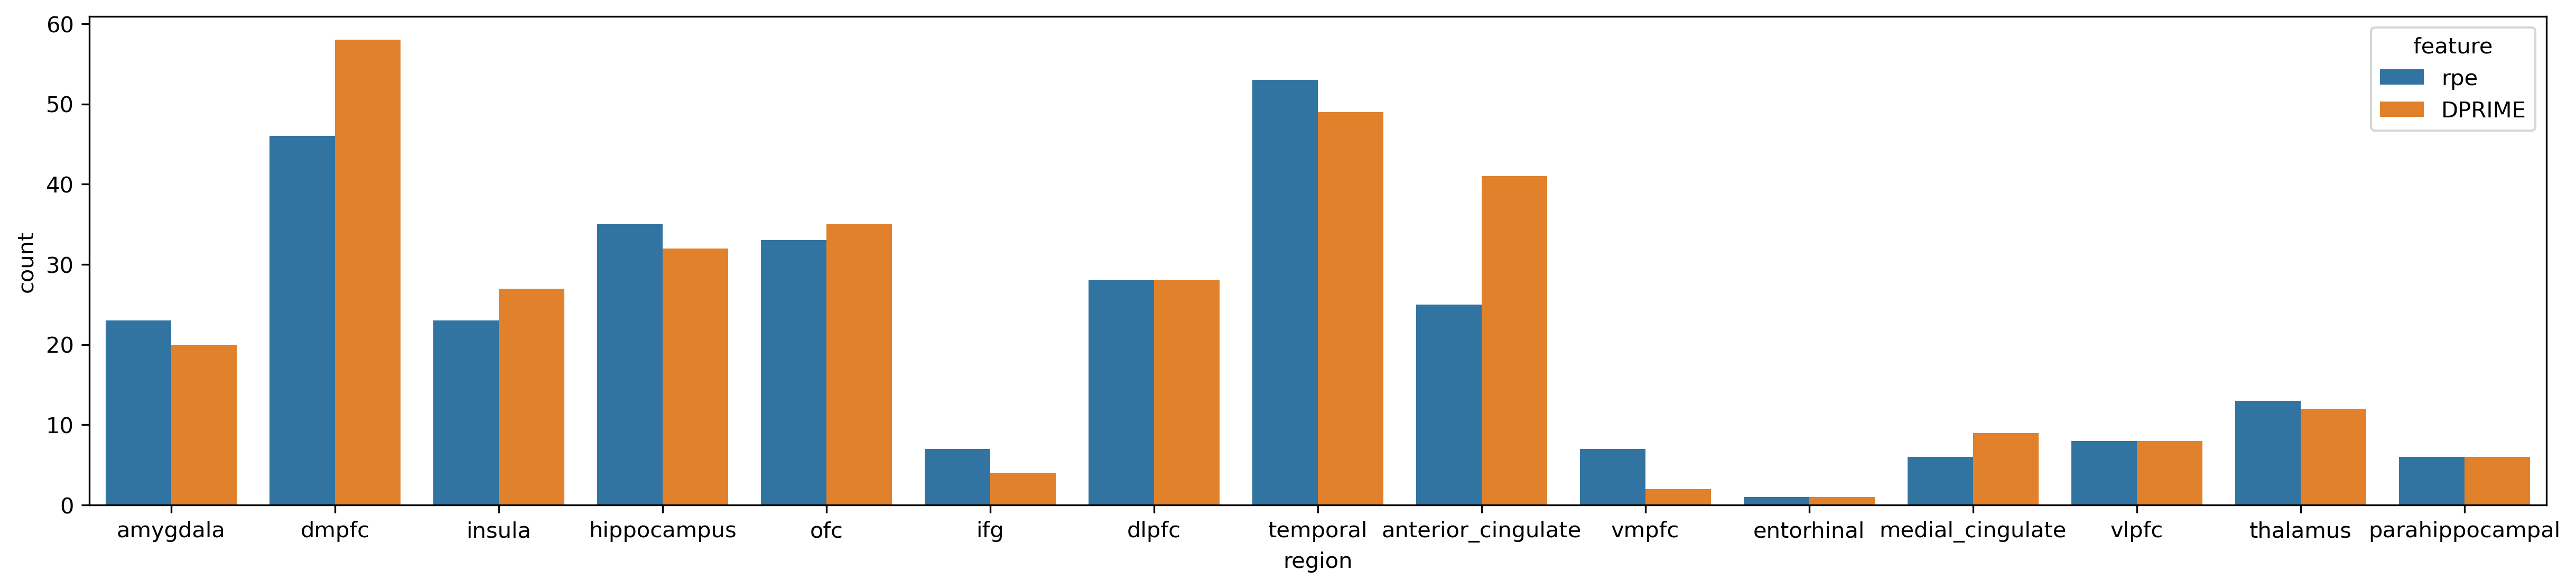

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(20, 4), dpi=300)
sns.barplot(data=sig_chan_dfs[sig_chan_dfs.region!='Unknown'], x='region', y='count', hue='feature')


<AxesSubplot:xlabel='region', ylabel='count'>

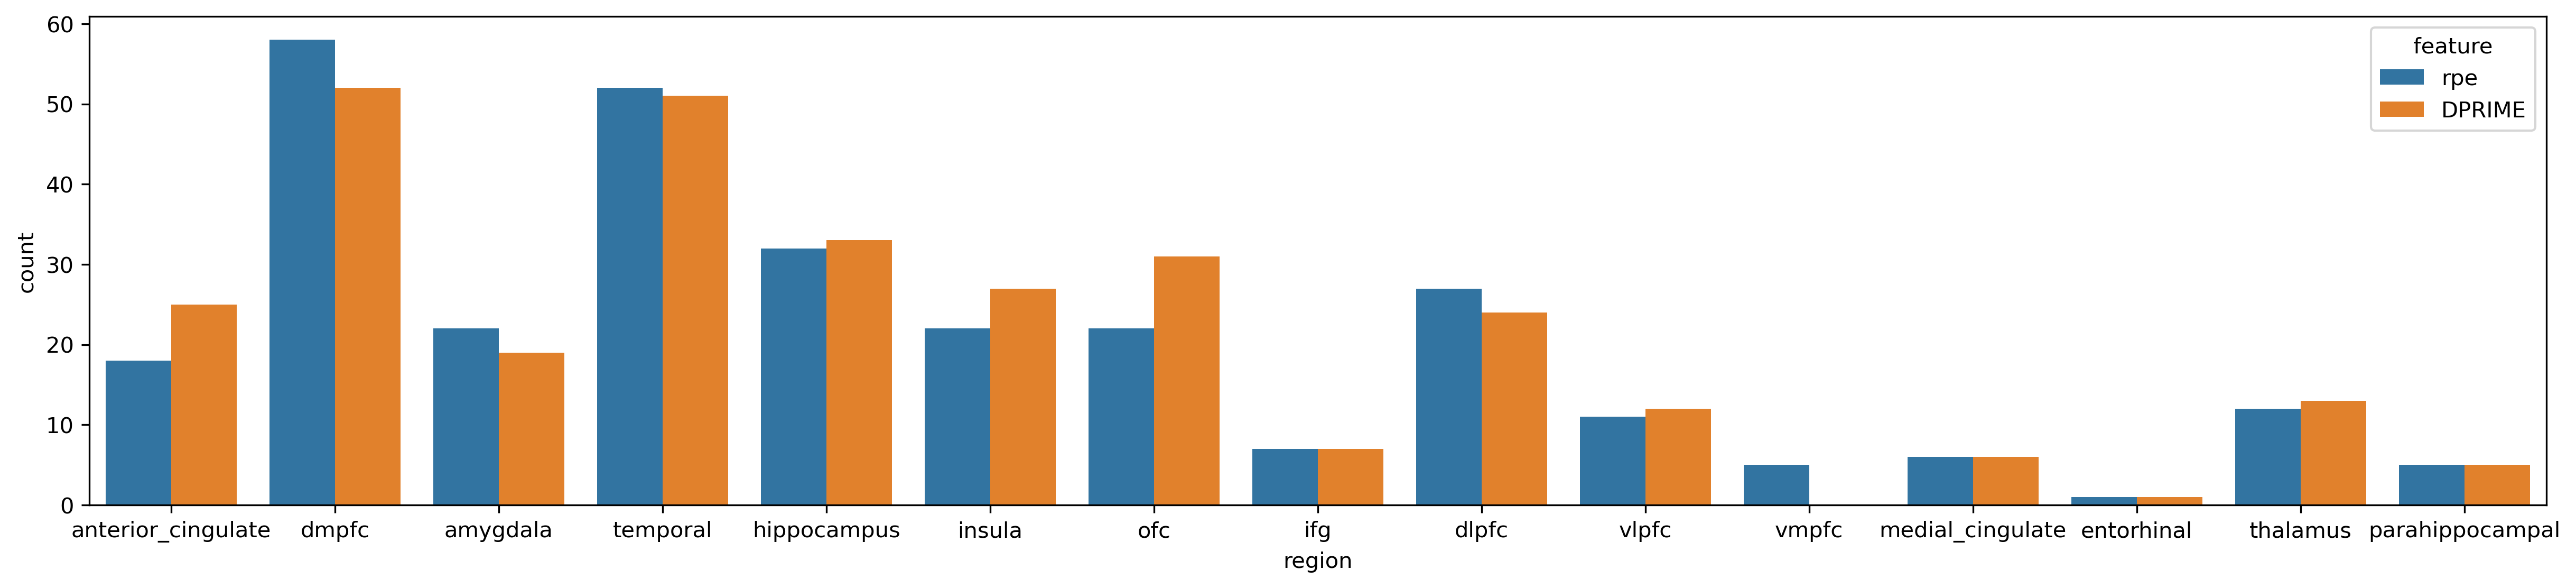

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(20, 4), dpi=300)
sns.barplot(data=sig_chan_dfs[sig_chan_dfs.region!='Unknown'], x='region', y='count', hue='feature')
